In [1]:
import tensorflow as tf
import numpy as np
import pickle
from tensorflow.python.platform import gfile
from random import randint
import os
import scipy.misc 
from matplotlib import pyplot as plt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('../data/mnist', one_hot=True)

Extracting ../data/mnist/train-images-idx3-ubyte.gz
Extracting ../data/mnist/train-labels-idx1-ubyte.gz
Extracting ../data/mnist/t10k-images-idx3-ubyte.gz
Extracting ../data/mnist/t10k-labels-idx1-ubyte.gz


In [3]:
def weight_varible(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [4]:
def unpool(value, name='unpool'):
    """N-dimensional version of the unpooling operation from
    https://www.robots.ox.ac.uk/~vgg/rg/papers/Dosovitskiy_Learning_to_Generate_2015_CVPR_paper.pdf
    :param value: A Tensor of shape [b, d0, d1, ..., dn, ch]
    :return: A Tensor of shape [b, 2*d0, 2*d1, ..., 2*dn, ch]
    """
    with tf.name_scope(name) as scope:
        sh = value.get_shape().as_list()
        dim = len(sh[1:-1])
        out = (tf.reshape(value, [-1] + sh[-dim:]))
        for i in range(dim, 0, -1):
            out = tf.concat([out, out],i)
        out_size = [-1] + [s * 2 for s in sh[1:-1]] + [sh[-1]]
        out = tf.reshape(out, out_size, name=scope)
    return out

In [5]:
batchsize = 50
imagesize = 28

sess = tf.InteractiveSession()
# paras
W_conv1 = weight_varible([5, 5, 1, 32])
b_conv1 = bias_variable([32])

# conv layer-1
x = tf.placeholder(tf.float32, [None, 784])
x_image = tf.reshape(x, [-1, 28, 28, 1])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# conv layer-2
W_conv2 = weight_varible([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# full connection
W_fc1 = weight_varible([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7 * 7 * 64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# dropout
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# output layer: softmax
W_fc2 = weight_varible([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
y_ = tf.placeholder(tf.float32, [None, 10])

# model training
cross_entropy = -tf.reduce_sum(y_ * tf.log(y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

sess.run(tf.global_variables_initializer())


for i in range(1000):
    batch = mnist.train.next_batch(50)

    if i % 100 == 0:
        train_accuacy = accuracy.eval(feed_dict={x: batch[0], y_: batch[1], keep_prob: 1.0})
        ##t.eval() is a shortcut for calling tf.get_default_session().run(t)
        print("step %d, training accuracy %g"%(i, train_accuacy))
    train_step.run(feed_dict = {x: batch[0], y_: batch[1], keep_prob: 0.5})

# accuacy on test
print("test accuracy %g"%(accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0})))

step 0, training accuracy 0.08
step 100, training accuracy 0.82
step 200, training accuracy 0.92
step 300, training accuracy 0.9
step 400, training accuracy 0.96
step 500, training accuracy 0.94
step 600, training accuracy 0.98
step 700, training accuracy 0.94
step 800, training accuracy 1
step 900, training accuracy 0.96
test accuracy 0.9645


In [16]:
#Reconstruction from the layer CNV-1
featuresReLu_1 = tf.placeholder(tf.float32,[None,14,14,32])
unPool_1 = unpool(featuresReLu_1)
unReLu_1 = tf.nn.relu(unPool_1)
unBias_1 = unReLu_1
unBias_1
#unConv = tf.nn.conv2d_transpose(unBias, W_conv1, output_shape=[1,28,28,1] , strides=[1,1,1,1], padding="SAME")
unConv_1 = tf.nn.conv2d_transpose(unBias_1, W_conv1, output_shape=[batchsize,28,28,1] , strides=[1,1,1,1], padding="SAME")

In [17]:
#Get the features from the layer CNV-1
activations1 = h_pool1.eval(feed_dict={x: mnist.train.next_batch(50)[0], y_: mnist.train.next_batch(50)[1]})
print (activations1.shape)

(50, 14, 14, 32)


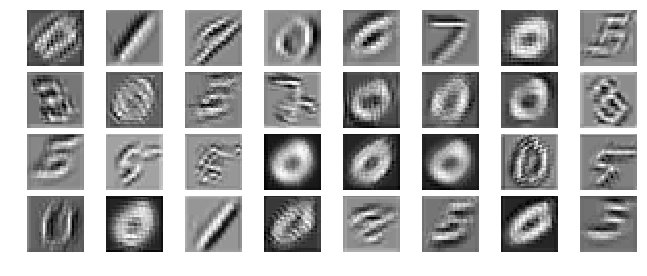

In [18]:
#get every feature (1, 14, 14, 1) from activations1 than reconstruct from 
plt.figure(num='CNV1',figsize=(10,8))
for i in range(32):
    isolated = activations1.copy()
    isolated[:,:,:,:i] = 0
    isolated[:,:,:,i+1:] = 0#These two lines set all other features other than feature i to 0
    #print (isolated.shape)
    totals = np.sum(isolated,axis=(1,2,3))
    best = np.argmax(totals,axis=0)
    #These two lines are particular for batch of images.
    #That means choose one image from this batch of images which feacture i can judge best.
    #print (totals)
    pixelactive = unConv_1.eval(feed_dict={featuresReLu_1: isolated})
    #print(pixelactive.shape) 
    #shape of every pixelactive is (50, 28, 28, 1) batchsize=50 picsize=28*28 colors=1
    plt.subplot(4,8,i+1)    
    plt.imshow(pixelactive[best,:,:,0],cmap="gray")
    plt.axis('off') 
plt.subplots_adjust(top=0.5, bottom=0.08, left=0.10, right=0.95, hspace=0.1,
                    wspace=0.35)
plt.show()

In [15]:
#Get the features from the layer CNV-2
activations2 = h_pool2.eval(feed_dict={x: mnist.train.next_batch(50)[0], y_: mnist.train.next_batch(50)[1]})
print (activations2.shape)

(50, 7, 7, 64)


In [21]:
#Reconstruction from the layer CNV-2
featuresReLu_2 = tf.placeholder(tf.float32,[None,7,7,64])
unPool_2 = unpool(featuresReLu_2)
unReLu_2 = tf.nn.relu(unPool_2)
unBias_2 = unReLu_2
unBias_2
#unConv = tf.nn.conv2d_transpose(unBias, W_conv1, output_shape=[1,28,28,1] , strides=[1,1,1,1], padding="SAME")
unConv_2 = tf.nn.conv2d_transpose(unBias_2, W_conv2, output_shape=[batchsize,14,14,32] , strides=[1,1,1,1], padding="SAME")
unPool_1 = unpool(unConv_2)
unReLu_1 = tf.nn.relu(unPool_1)
unBias_1 = unReLu_1
unBias_1
#unConv = tf.nn.conv2d_transpose(unBias, W_conv1, output_shape=[1,28,28,1] , strides=[1,1,1,1], padding="SAME")
unConv_1 = tf.nn.conv2d_transpose(unBias_1, W_conv1, output_shape=[batchsize,28,28,1] , strides=[1,1,1,1], padding="SAME")

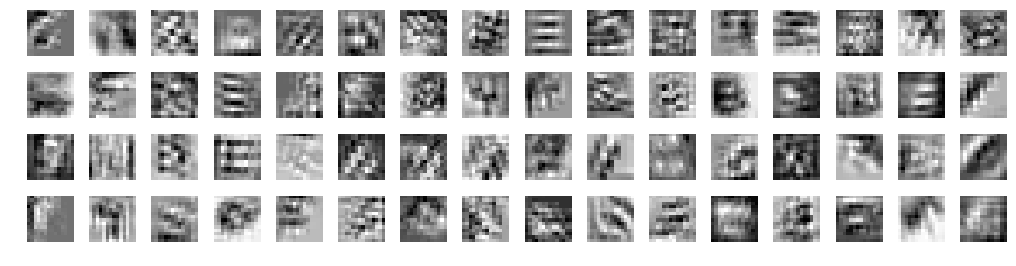

In [29]:
#get every feature (1, 14, 14, 1) from activations1 than reconstruct from 
plt.figure(num='CNV2',figsize=(16,8))
for i in range(64):
    isolated = activations2.copy()
    isolated[:,:,:,:i] = 0
    isolated[:,:,:,i+1:] = 0#These two lines set all other features other than feature i to 0
    #print (isolated.shape)
    totals = np.sum(isolated,axis=(1,2,3))
    best = np.argmax(totals,axis=0)
    #These two lines are particular for batch of images.
    #That means choose one image from this batch of images which feacture i can judge best.
    #print (totals)
    pixelactive = unConv_2.eval(feed_dict={featuresReLu_2: isolated})
    #print(pixelactive.shape) 
    #shape of every pixelactive is (50, 28, 28, 1) batchsize=50 picsize=28*28 colors=1
    plt.subplot(4,16,i+1)    
    plt.imshow(pixelactive[best,:,:,0],cmap="gray")
    plt.axis('off') 
plt.subplots_adjust(top=0.5, bottom=0.08, left=0.10, right=0.95, hspace=0.1,
                    wspace=0.35)
plt.show()

In [27]:
activations3 = h_fc1.eval(feed_dict={x: mnist.train.next_batch(50)[0], y_: mnist.train.next_batch(50)[1]})
activations3.shape

(50, 1024)